In [1]:
import sys
sys.path.append("..")

In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
load_dotenv(find_dotenv(".env.local"))

True

In [3]:
from pathlib import Path

In [4]:
version_dir = Path("/Users/krzm048/Repos/GENAI244OpsProcurementPoC/data/versions/v0.1")

In [5]:
conf_path = version_dir / "conf.yml"

In [6]:
from messages import MessageHistory
from rag import RAG
from src.vectordb import VDB
from src.retriever import Retriever

In [7]:
from omegaconf import OmegaConf
config = OmegaConf.load(conf_path)

In [8]:
vdb = VDB(path=version_dir, **config['VDB'])

In [9]:
retriever = Retriever(vdb, **config['Retriever'])

In [10]:
message_manager = MessageHistory('evaluation', "0", version_dir)

In [11]:
rag = RAG(retriever=retriever, message_manager=message_manager, **config['RAG'])

In [12]:
# vdb.add_pdfs([p for p in (version_dir / "files").iterdir()])

In [13]:
import pandas as pd
questions_df = pd.read_csv("../Evaluation/eval_v1.csv")

In [14]:
q_dict = questions_df.to_dict(orient="index")
q_dict[0]

{'question': 'What payment terms should be used in France',
 'ground_truth': 'The payment terms to be used in France should be 45 days.'}

In [15]:
from src.costs import costs_per_1M_tokens
for i in q_dict:
    message_manager.change_instance('evaluation', str(i))
    response, chunks = rag.query(q_dict[i]['question'])
    q_dict[i]['response'] = response.choices[0].message.content
    q_dict[i]['context'] = "\n".join(chunks['documents'][0])
    q_dict[i]['completion_tokens'] = response.usage.completion_tokens
    q_dict[i]['prompt_tokens'] = response.usage.prompt_tokens
    q_dict[i]['meta_data'] = chunks['metadatas'][0]
    q_dict[i]['context_ids'] = chunks['ids'][0]
    q_dict[i]['context_distances'] = chunks['distances'][0]
    model = config['RAG']['model']
    q_dict[i]['completion_cost'] = costs_per_1M_tokens[model].completion * q_dict[i]['completion_tokens'] / 1000000.
    q_dict[i]['prompt_cost'] = costs_per_1M_tokens[model].prompt * q_dict[i]['prompt_tokens'] / 1000000.


Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.
Log file not found.


In [19]:
from uptrain import EvalLLM, ResponseMatching, Settings, Evals
import os
settings = Settings(
    model="azure/"+config['Evaluation']['model'], 
    azure_api_key=os.getenv("AZURE_OPENAI_API_KEY"), 
    azure_api_version=config['Evaluation']['api_version'], 
    azure_api_base=os.getenv("AZURE_OPENAI_ENDPOINT")
    )
eval_llm = EvalLLM(settings)

/Users/krzm048/Repos/GENAI244OpsProcurementPoC/.venv/lib/python3.10/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


In [20]:
res = eval_llm.evaluate(
    data = list(q_dict.values()),
    checks = [ResponseMatching(method = 'llm'), Evals.CONTEXT_RELEVANCE, Evals.FACTUAL_ACCURACY, Evals.RESPONSE_RELEVANCE]    # method: llm/exact/rouge
)

2024-04-03 11:34:10.651 | WARNING  | uptrain.operators.language.llm:fetch_responses:260 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 40/40 [00:06<00:00,  5.75it/s]
/Users/krzm048/Repos/GENAI244OpsProcurementPoC/.venv/lib/python3.10/site-packages/uptrain/operators/language/llm.py:263: RuntimeWarning: coroutine 'LLMMulticlient.async_fetch_responses' was never awaited
  with ThreadPoolExecutor(max_workers=1) as executor:
2024-04-03 11:34:17.829 | WARNING  | uptrain.operators.language.llm:fetch_responses:260 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 40/40 [00:21<00:00,  1.90it/s]
2024-04-03 11:34:39.472 | WARNING  | uptrain.operators.language.llm:fetch_responses:260 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 20/20 [00:05<00:00,  3.58it/s]
2024-04-03 11:34:45.086 | WARNING  | uptrain.operators.language.llm:fetch_responses:260 - Detected a running 

In [21]:
res

[{'question': 'What payment terms should be used in France',
  'ground_truth': 'The payment terms to be used in France should be 45 days.',
  'response': 'In France, the standard payment term for AstraZeneca is 45 days. Therefore, when negotiating an agreement with a supplier located in France, the payment term should be set at 45 days.',
  'context': 'Are late payments possible? • Does the Vendor’s bear high initial costs justifying upfront payments?\n\nKEY PAYMENT RULES\n\nThe key rules to be followed by when negotiating agreement with a supplier:\n\nRule 1\n\nApply 60 days PT to transactions in which Vendor is located in the EU or Switzerland, Norway, UK, with an exception to suppliers located in France, in which case 45 days PT shall apply.\n\nRule 2\n\nApply 75 days PT to transactions in which Vendor is located outside of EU or Switzerland, Norway or UK.\nhttps://www.linguee.es/espanol- ingles/traduccion/texto+legal.html\n\n43\n\nPAYMENT TERMS\n\nREMEMBER\n\nINTRODUCTORY REMARKS\n

In [27]:
eval_df = pd.DataFrame.from_dict(res)
eval_df.columns

Index(['question', 'ground_truth', 'response', 'context', 'completion_tokens',
       'prompt_tokens', 'meta_data', 'context_ids', 'context_distances',
       'completion_cost', 'prompt_cost', 'score_response_matching',
       'explanation_response_matching', 'score_response_match_recall',
       'score_response_match_precision', 'score_context_relevance',
       'explanation_context_relevance', 'score_factual_accuracy',
       'explanation_factual_accuracy', 'score_response_relevance',
       'explanation_response_relevance'],
      dtype='object')

In [23]:
eval_df.to_csv(version_dir / "evaluation.csv")

In [30]:
score_cols = ['score_response_matching', 'score_response_match_recall', 'score_response_match_precision', 'score_context_relevance', 'score_factual_accuracy', 'score_response_relevance']

In [37]:
import matplotlib.pyplot as plt

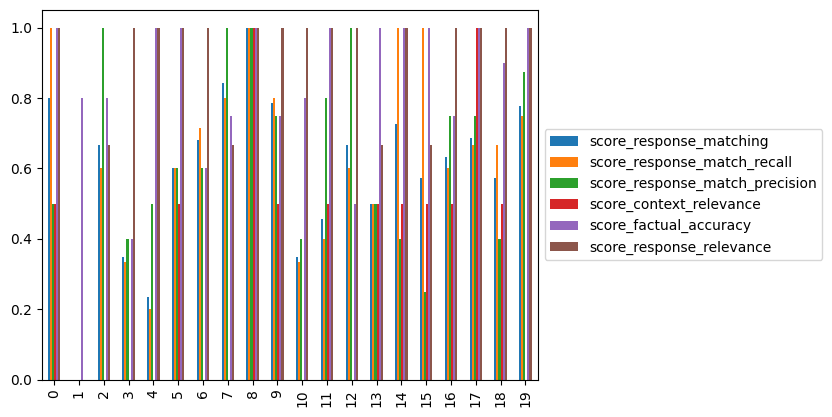

In [46]:
fig, ax = plt.subplots()
eval_df[score_cols].plot.bar(stacked=False, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.figure.savefig(version_dir / "eval_scores_bar.png", bbox_inches='tight')

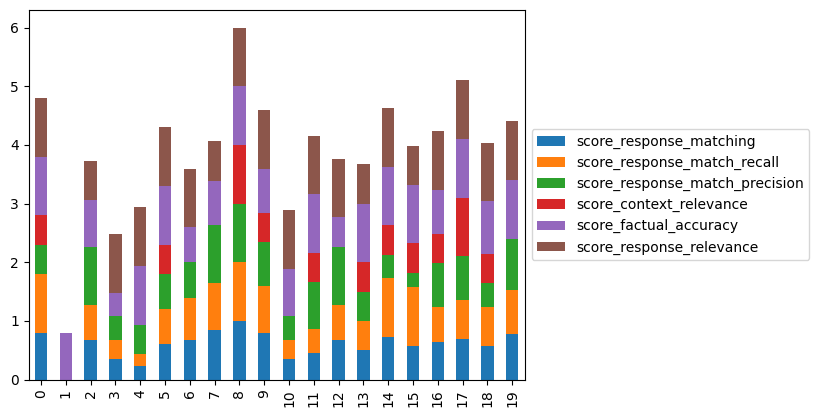

In [47]:
fig, ax = plt.subplots()
eval_df[score_cols].plot.bar(stacked=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.figure.savefig(version_dir / "eval_scores_bar_stacked.png", bbox_inches='tight')

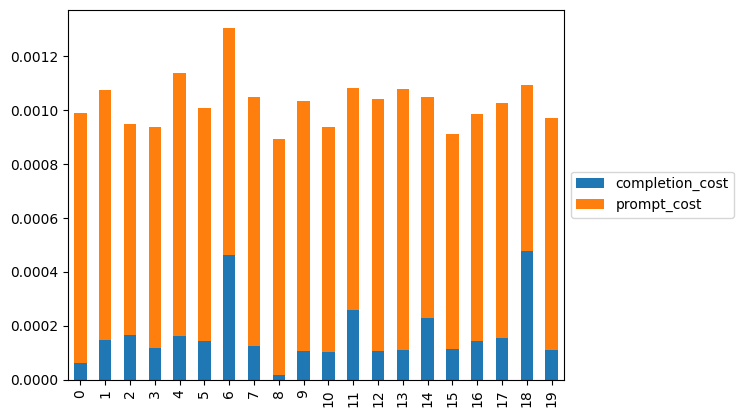

In [48]:
fig, ax = plt.subplots()
eval_df[['completion_cost', 'prompt_cost']].plot.bar(stacked=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.figure.savefig(version_dir / "costs_bar.png", bbox_inches='tight')